In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /Users/misakiryo/opt/anaconda3/lib/python3.8/site-packages (2.4.1)


In [2]:
!pip install --upgrade tensorflow_hub

Requirement already up-to-date: tensorflow_hub in /Users/misakiryo/opt/anaconda3/lib/python3.8/site-packages (0.11.0)


### Ploblem 1.

#### モジュールのインポートと構成

In [3]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#### 画像をダウンロードして、スタイル画像とコンテンツ画像を選択します。

In [6]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

### 入力を視覚化する
#### 画像をロードし、その最大サイズを512ピクセルに制限する関数を定義します。

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#### 画像を表示する簡単な関数を作成します。

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

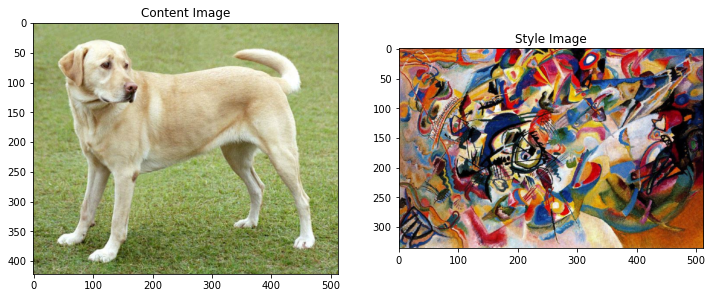

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### TFハブを使用した高速スタイル転送
#### このチュートリアルでは、画像コンテンツを特定のスタイルに最適化する、元のスタイル転送アルゴリズムを示します。詳細に入る前に、 TensorFlowハブモデルがこれをどのように行うかを見てみましょう。

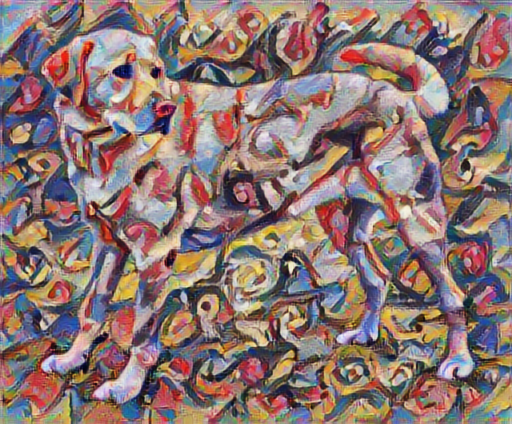

In [10]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### コンテンツとスタイルの表現を定義する
#### モデルの中間レイヤーを使用して、画像のコンテンツとスタイルの表現を取得します。ネットワークの入力レイヤーから始めて、最初のいくつかのレイヤーのアクティブ化は、エッジやテクスチャなどの低レベルの機能を表します。ネットワークをステップスルーすると、最後のいくつかのレイヤーは、より高いレベルの機能（ホイールや目などのオブジェクトパーツ）を表します。この場合、事前にトレーニングされた画像分類ネットワークであるVGG19ネットワークアーキテクチャを使用しています。これらの中間レイヤーは、画像からコンテンツとスタイルの表現を定義するために必要です。入力画像の場合、これらの中間レイヤーで対応するスタイルとコンテンツターゲットの表現を一致させてみてください。

#### VGG19をロードし、イメージでテスト実行して、正しく使用されていることを確認します。

In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 34s 0us/step


TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 1us/step


[('Labrador_retriever', 0.4931726),
 ('golden_retriever', 0.23665185),
 ('kuvasz', 0.036357313),
 ('Chesapeake_Bay_retriever', 0.024182772),
 ('Greater_Swiss_Mountain_dog', 0.018646035)]

#### 次に、分類ヘッドなしでVGG19をロードし、レイヤー名をリストします。

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 3s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### ネットワークから中間​​レイヤーを選択して、画像のスタイルとコンテンツを表します。

In [14]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### スタイルとコンテンツの中間レイヤー

#### では、事前にトレーニングされた画像分類ネットワーク内のこれらの中間出力により、スタイルとコンテンツの表現を定義できるのはなぜですか？


#### 大まかに言えば、ネットワークが画像分類（このネットワークが行うように訓練されている）を実行するためには、画像を理解する必要があります。これには、生の画像を入力ピクセルとして取得し、生の画像のピクセルを画像内に存在する特徴の複雑な理解に変換する内部表現を構築する必要があります。


#### これは、畳み込みニューラルネットワークがうまく一般化できる理由でもあります。それらは、バックグラウンドノイズやその他の迷惑にとらわれないクラス（猫と犬など）内の不変性と定義機能をキャプチャできます。したがって、生の画像がモデルに入力される場所と出力分類ラベルの間のどこかで、モデルは複雑な特徴抽出器として機能します。モデルの中間レイヤーにアクセスすることで、入力画像のコンテンツとスタイルを説明できます。


### モデルを構築する

#### tf.keras.applicationsのネットワークは、 tf.keras.applications機能APIを使用して中間層の値を簡単に抽出できるように設計されています。


#### 機能APIを使用してモデルを定義するには、入力と出力を指定します。


#### model = Model(inputs, outputs)


#### 次の関数は、中間層の出力のリストを返すVGG19モデルを作成します。

In [15]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

#### そして、モデルを作成するには

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



### スタイルを計算する
#### 画像の内容は、中間特徴マップの値で表されます。

#### 結局のところ、画像のスタイルは、さまざまな特徴マップ間の平均と相関関係によって説明できます。特徴ベクトルの外積を各位置でそれ自体と取り、その外積をすべての場所で平均することにより、この情報を含むグラム行列を計算します。このグラム行列は、特定のレイヤーについて次のように計算できます。

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

#### これは、 tf.linalg.einsum関数を使用して簡潔に実装できます。

In [17]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### スタイルとコンテンツを抽出する
#### スタイルとコンテンツテンソルを返すモデルを作成します。

In [18]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

#### 画像で呼び出されると、このモデルはstyle_layersグラム行列（スタイル）とcontent_layersコンテンツを返します。

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228476
    max:  28014.568
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.504
    mean:  9100.95

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764152


### 最急降下法を実行します
#### このスタイルとコンテンツの抽出機能を使用して、スタイル転送アルゴリズムを実装できるようになりました。これを行うには、各ターゲットに対する画像の出力の平均二乗誤差を計算し、これらの損失の加重和を取ります。

#### スタイルとコンテンツのターゲット値を設定します。

In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#### 最適化する画像を含むtf.Variableを定義します。これをすばやく行うには、コンテンツイメージで初期化します（ tf.Variableはコンテンツイメージと同じ形状である必要があります）。

In [21]:
image = tf.Variable(content_image)

#### これはフロート画像なので、ピクセル値を0から1の間に保つ関数を定義します。

In [22]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### オプティマイザを作成します。この論文ではLBFGSを推奨していますが、 Adamも問題なく機能します。

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#### これを最適化するには、2つの損失の加重組み合わせを使用して、合計損失を取得します。

In [24]:
style_weight=1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#### tf.GradientTapeを使用して画像を更新します。

In [26]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### 次に、いくつかの手順を実行してテストします。

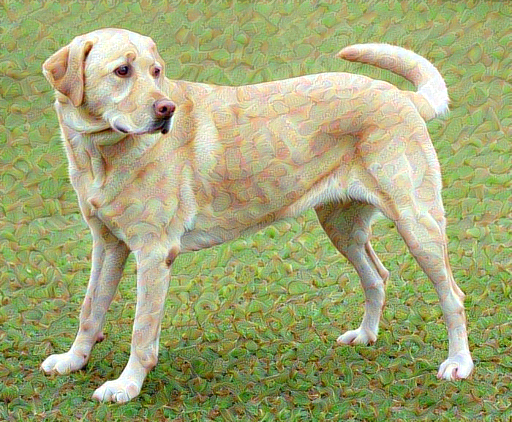

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

#### 動作しているので、より長い最適化を実行します。




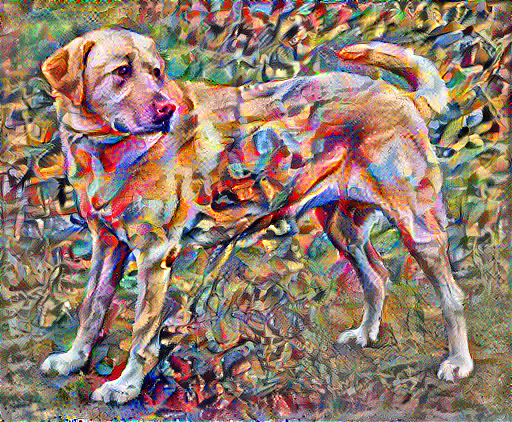

Train step: 1000
Total time: 7399.5


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### 全変動損失
#### この基本的な実装の欠点の1つは、高周波のアーティファクトが多数生成されることです。画像の高周波成分に明示的な正則化項を使用して、これらを減らします。スタイル転送では、これはしばしば全変動損失と呼ばれます。


In [29]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

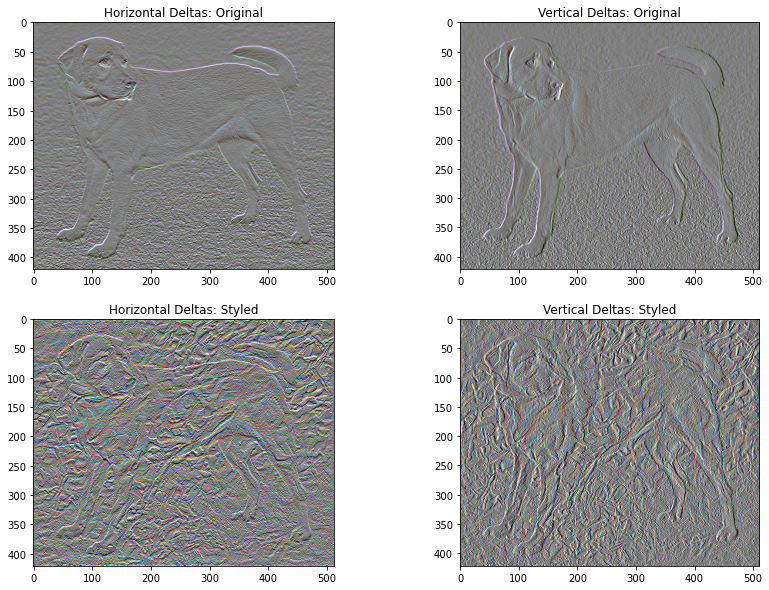

In [30]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

#### これは、高周波成分がどのように増加したかを示しています。

#### また、この高周波成分は基本的にエッジ検出器です。 Sobelエッジ検出器から同様の出力を取得できます。次に例を示します。

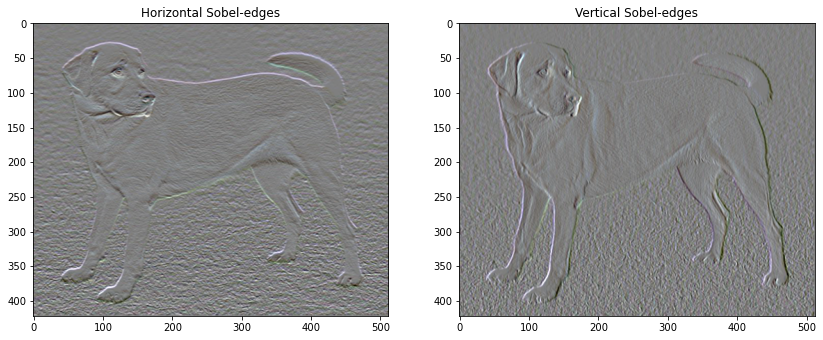

In [31]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

#### これに関連する正則化損失は、値の2乗の合計です。

In [32]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [33]:
total_variation_loss(image).numpy()

149503.84

#### それはそれが何をするかを示しました。ただし、自分で実装する必要はありません。TensorFlowには標準の実装が含まれています。

In [34]:
tf.image.total_variation(image).numpy()

array([149503.84], dtype=float32)

### 最適化を再実行します
#### total_variation_loss重みを選択しtotal_variation_loss

In [35]:
total_variation_weight=30

#### 次に、 train_step関数にtrain_stepます。

In [36]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### 最適化変数を再初期化します。

In [37]:
image = tf.Variable(content_image)

#### そして、最適化を実行します。

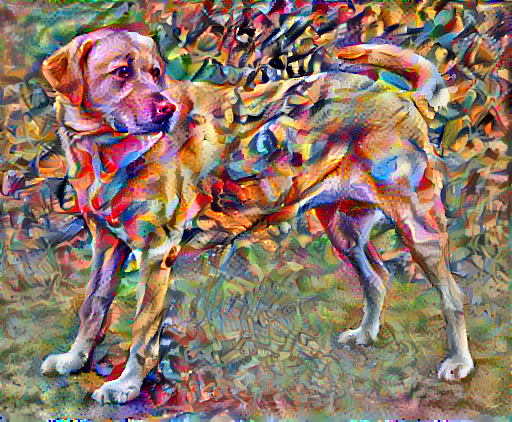

Train step: 1000
Total time: 5092.6


In [38]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#### 最後に、結果を保存します。

In [39]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

### Ploblem 2(Adv).

### Ploblem 3.

Epoch 1/500
3/3 [==============================] - 1s 6ms/step - loss: 0.4923 - accuracy: 0.5969
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 0.4551 - accuracy: 0.6562
Epoch 3/500
3/3 [==============================] - 0s 5ms/step - loss: 0.4765 - accuracy: 0.6312
Epoch 4/500
3/3 [==============================] - 0s 4ms/step - loss: 0.4391 - accuracy: 0.6586
Epoch 5/500
3/3 [==============================] - 0s 6ms/step - loss: 0.4647 - accuracy: 0.6594
Epoch 6/500
3/3 [==============================] - 0s 5ms/step - loss: 0.4287 - accuracy: 0.6969
Epoch 7/500
3/3 [==============================] - 0s 15ms/step - loss: 0.4262 - accuracy: 0.6852
Epoch 8/500
3/3 [==============================] - 0s 4ms/step - loss: 0.4274 - accuracy: 0.6898
Epoch 9/500
3/3 [==============================] - 0s 11ms/step - loss: 0.4326 - accuracy: 0.7023
Epoch 10/500
3/3 [==============================] - 0s 6ms/step - loss: 0.4126 - accuracy: 0.7008
Epoch 11/500
3/3 [=========

3/3 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 1.0000
Epoch 84/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 1.0000
Epoch 85/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0540 - accuracy: 1.0000
Epoch 86/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0597 - accuracy: 1.0000
Epoch 87/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0519 - accuracy: 1.0000
Epoch 88/500
3/3 [==============================] - 0s 13ms/step - loss: 0.0539 - accuracy: 1.0000
Epoch 89/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0513 - accuracy: 1.0000
Epoch 90/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 1.0000
Epoch 91/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0461 - accuracy: 1.0000
Epoch 92/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0444 - accuracy: 1.0000
Epoch 93/500
3/3 [==============

3/3 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 166/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 167/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 168/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 169/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 170/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 171/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0115 - accuracy: 1.0000
Epoch 172/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 173/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 174/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 175/500
3/3 [=====

3/3 [==============================] - 0s 6ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 248/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 249/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 250/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 251/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 252/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 253/500
3/3 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 254/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 255/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 256/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 257/500
3/3 [==

3/3 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 330/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 331/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 332/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 333/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 334/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 335/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 336/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 337/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 338/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 339/500
3/3 [===

3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 411/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 412/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 413/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 414/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 415/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 416/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 417/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 418/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 419/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 420/500
3/3 [=

3/3 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 492/500
3/3 [==============================] - 0s 6ms/step - loss: 9.9459e-04 - accuracy: 1.0000
Epoch 493/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 494/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 495/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 496/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 497/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 498/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 499/500
3/3 [==============================] - 0s 4ms/step - loss: 9.5612e-04 - accuracy: 1.0000
Epoch 500/500
1/1 [==============================] - 0s 415ms/step - loss: 0.0014 - accuracy: 1.0000
Test score 0.0

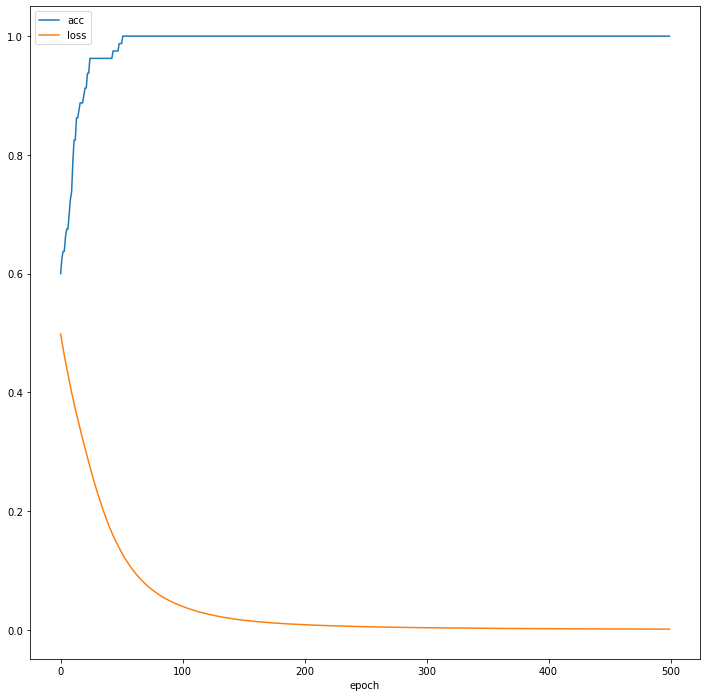

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from keras.models import Sequential
from keras.layers import Dense,  Activation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

iris = datasets.load_iris() # データを取得
x = iris.data[:100]   # 花の特徴量、長さなど
y = iris.target[:100] # 0, 1, 2のラベル
x = preprocessing.scale(x)  # 標準化

y = np_utils.to_categorical(y)  # one-hotエンコード.例) 1 => [0, 1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)    # 教師データとテストデータに分割

# モデルの生成
model = Sequential()
model.add(Dense(10, input_dim=4))    # 入力層4ノード, 隠れ層に10ノード, 全結合
model.add(Activation("relu"))    # 活性化関数はsigmoid
model.add(Dense(2)) # 出力層2ノード,全結合
model.add(Activation("sigmoid"))

model.compile(loss="categorical_crossentropy",   # 誤差関数
              optimizer="adam",     # 最適化手法
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs =500, batch_size=32) # 学習
# 学習過程のプロット
plt.plot(history.epoch, history.history["accuracy"], label="acc")
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.xlabel("epoch")
plt.legend()

# 評価
score = model.evaluate(x_test, y_test, verbose=1)
print("Test score", score[0])
print("Test accuracy", score[1])

# 個々のデータを入力して学習できているか見てみる
print("====================================")
print("-----------correct answer-----------")
print(y_test[0])
print(y_test[10])
print("-----------predict answer-----------")
print(np.round(model.predict(x_test)[0]))
print(np.round(model.predict(x_test)[10]))

### Ploblem 4.

Epoch 1/500
4/4 [==============================] - 1s 2ms/step - loss: 1.2217 - accuracy: 0.3967
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 1.1688 - accuracy: 0.4092
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 1.1918 - accuracy: 0.4221
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 1.1798 - accuracy: 0.4142
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 1.1410 - accuracy: 0.4581
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 1.1274 - accuracy: 0.4533
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 1.1524 - accuracy: 0.4535
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 1.0987 - accuracy: 0.4796
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0992 - accuracy: 0.4896
Epoch 10/500
4/4 [==============================] - 0s 11ms/step - loss: 1.0557 - accuracy: 0.5260
Epoch 11/500
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.7633
Epoch 84/500
4/4 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.7810
Epoch 85/500
4/4 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.7852
Epoch 86/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5939 - accuracy: 0.7863
Epoch 87/500
4/4 [==============================] - 0s 5ms/step - loss: 0.6048 - accuracy: 0.7738
Epoch 88/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5804 - accuracy: 0.8071
Epoch 89/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.7685
Epoch 90/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.7935
Epoch 91/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5824 - accuracy: 0.7925
Epoch 92/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5761 - accuracy: 0.7925
Epoch 93/500
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.4102 - accuracy: 0.8685
Epoch 167/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4344 - accuracy: 0.8581
Epoch 168/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.8719
Epoch 169/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4191 - accuracy: 0.8865
Epoch 170/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8854
Epoch 171/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.8938
Epoch 172/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4445 - accuracy: 0.8521
Epoch 173/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.9000
Epoch 174/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4173 - accuracy: 0.9169
Epoch 175/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8908
Epoch 176/500
4/4 [=====

4/4 [==============================] - 0s 4ms/step - loss: 0.3258 - accuracy: 0.9300
Epoch 248/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3469 - accuracy: 0.9071
Epoch 249/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3597 - accuracy: 0.8998
Epoch 250/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3340 - accuracy: 0.9008
Epoch 251/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.8967
Epoch 252/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3078 - accuracy: 0.9342
Epoch 253/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3512 - accuracy: 0.9060
Epoch 254/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3438 - accuracy: 0.9060
Epoch 255/500
4/4 [==============================] - 0s 6ms/step - loss: 0.3311 - accuracy: 0.9123
Epoch 256/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3235 - accuracy: 0.9290
Epoch 257/500
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.2773 - accuracy: 0.9044
Epoch 330/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2919 - accuracy: 0.9044
Epoch 331/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2528 - accuracy: 0.9231
Epoch 332/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2580 - accuracy: 0.9335
Epoch 333/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2663 - accuracy: 0.9294
Epoch 334/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2638 - accuracy: 0.9263
Epoch 335/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2593 - accuracy: 0.9252
Epoch 336/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.9617
Epoch 337/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2673 - accuracy: 0.9315
Epoch 338/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2835 - accuracy: 0.9263
Epoch 339/500
4/4 [=====

4/4 [==============================] - 0s 5ms/step - loss: 0.2104 - accuracy: 0.9446
Epoch 412/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1900 - accuracy: 0.9685
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2258 - accuracy: 0.9560
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1915 - accuracy: 0.9685
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9415
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9625
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2074 - accuracy: 0.9646
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2144 - accuracy: 0.9531
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2279 - accuracy: 0.9679
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2114 - accuracy: 0.9552
Epoch 421/500
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.1582 - accuracy: 0.9731
Epoch 494/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.9679
Epoch 495/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1687 - accuracy: 0.9648
Epoch 496/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.9679
Epoch 497/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1664 - accuracy: 0.9825
Epoch 498/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1706 - accuracy: 0.9700
Epoch 499/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1761 - accuracy: 0.9679
Epoch 500/500
1/1 [==============================] - 0s 410ms/step - loss: 0.2166 - accuracy: 0.9333
Test score 0.2165556252002716
Test accuracy 0.9333333373069763
-----------correct answer-----------
[0. 0. 1.]
[0. 0. 1.]
-----------predict answer-----------
[0. 0. 1.]
[0. 1. 1.]


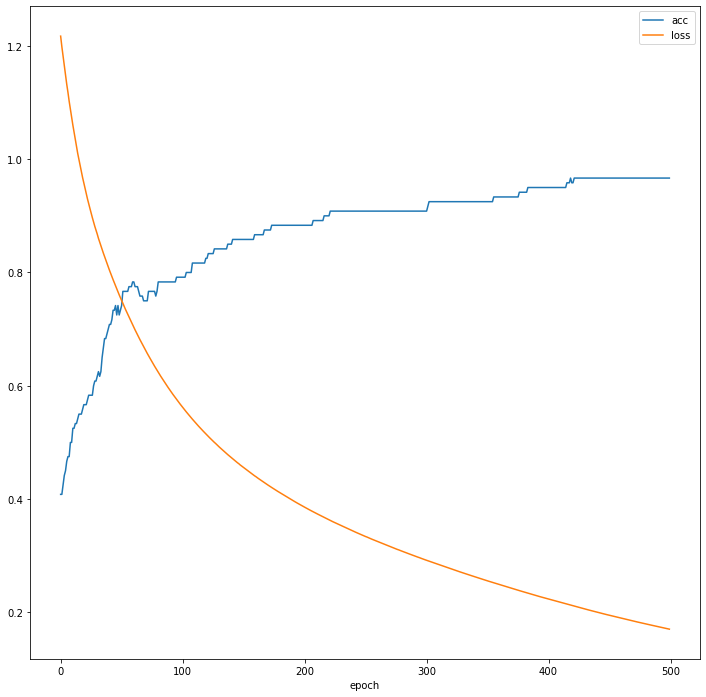

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from keras.models import Sequential
from keras.layers import Dense,  Activation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

iris = datasets.load_iris() # データを取得
x = iris.data   # 花の特徴量、長さなど
y = iris.target # 0, 1, 2のラベル
x = preprocessing.scale(x)  # 標準化

y = np_utils.to_categorical(y)  # one-hotエンコード.例) 1 => [0, 1, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)    # 教師データとテストデータに分割

# モデルの生成
model = Sequential()
model.add(Dense(10, input_dim=4))    # 入力層4ノード, 隠れ層に10ノード, 全結合
model.add(Activation("sigmoid"))    # 活性化関数はsigmoid
model.add(Dense(3)) # 出力層3ノード,全結合
model.add(Activation("sigmoid"))

model.compile(loss="categorical_crossentropy",   # 誤差関数
              optimizer="adam",     # 最適化手法
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs =500, batch_size=32) # 学習
# 学習過程のプロット
plt.plot(history.epoch, history.history["accuracy"], label="acc")
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.xlabel("epoch")
plt.legend()

# 評価
score = model.evaluate(x_test, y_test, verbose=1)
print("Test score", score[0])
print("Test accuracy", score[1])

# 個々のデータを入力して学習できているか見てみる
print("====================================")
print("-----------correct answer-----------")
print(y_test[0])
print(y_test[10])
print("-----------predict answer-----------")
print(np.round(model.predict(x_test)[0]))
print(np.round(model.predict(x_test)[10]))

### Ploblem 5.

In [96]:
import os
os.getcwd()

'/Users/misakiryo/diveintocode-ml/Sprint14'

In [111]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [112]:
df_train = pd.read_csv('/Users/misakiryo/diveintocode-ml/Sprint13/train.csv')

In [114]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

In [115]:
df_train = df_train.fillna(df_train.mean())

In [116]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

<ipython-input-116-2946051705ca>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);


In [123]:
df_train = pd.read_csv('/Users/misakiryo/diveintocode-ml/Sprint13/train.csv')

In [124]:
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
df_train = df_train[cols]
# Create dummy values
df_train = pd.get_dummies(df_train)
#filling NA's with the mean of the column:
df_train = df_train.fillna(df_train.mean())
# Always standard scale the data before using NN
scale = StandardScaler()
X_train = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]
X_train = scale.fit_transform(X_train)
# Y is just the 'SalePrice' column
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# split into 80% for train and 20% for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=seed)

In [125]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [126]:
model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_32 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_33 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 41        
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)

Epoch 1/150
37/37 [==============================] - 2s 28ms/step - loss: 38585738132.2105 - mean_absolute_error: 179392.6826 - val_loss: 41490194432.0000 - val_mean_absolute_error: 185089.1875
Epoch 2/150
37/37 [==============================] - 0s 7ms/step - loss: 40461045005.4737 - mean_absolute_error: 183463.3104 - val_loss: 41487912960.0000 - val_mean_absolute_error: 185083.6875
Epoch 3/150
37/37 [==============================] - 0s 7ms/step - loss: 38291461605.0526 - mean_absolute_error: 179470.7706 - val_loss: 41478860800.0000 - val_mean_absolute_error: 185062.5469
Epoch 4/150
37/37 [==============================] - 0s 5ms/step - loss: 37151181069.4737 - mean_absolute_error: 177608.1147 - val_loss: 41450622976.0000 - val_mean_absolute_error: 184998.1094
Epoch 5/150
37/37 [==============================] - 0s 8ms/step - loss: 37634270046.3158 - mean_absolute_error: 178247.4017 - val_loss: 41382326272.0000 - val_mean_absolute_error: 184844.0625
Epoch 6/150
37/37 [===============

Epoch 44/150
37/37 [==============================] - 0s 6ms/step - loss: 3255030238.3158 - mean_absolute_error: 44102.9388 - val_loss: 3436070912.0000 - val_mean_absolute_error: 44969.1523
Epoch 45/150
37/37 [==============================] - 0s 5ms/step - loss: 3717744256.0000 - mean_absolute_error: 43279.6651 - val_loss: 3399620352.0000 - val_mean_absolute_error: 44723.8125
Epoch 46/150
37/37 [==============================] - 0s 5ms/step - loss: 3074629106.5263 - mean_absolute_error: 41535.6712 - val_loss: 3348057600.0000 - val_mean_absolute_error: 44360.3828
Epoch 47/150
37/37 [==============================] - 0s 5ms/step - loss: 3688347506.5263 - mean_absolute_error: 44307.6376 - val_loss: 3306713088.0000 - val_mean_absolute_error: 44061.7695
Epoch 48/150
37/37 [==============================] - 0s 5ms/step - loss: 3357152801.6842 - mean_absolute_error: 42843.0529 - val_loss: 3262498048.0000 - val_mean_absolute_error: 43747.5625
Epoch 49/150
37/37 [==============================

37/37 [==============================] - 0s 6ms/step - loss: 1572349699.3684 - mean_absolute_error: 29009.7322 - val_loss: 1769322112.0000 - val_mean_absolute_error: 30932.1504
Epoch 88/150
37/37 [==============================] - 0s 4ms/step - loss: 2311882509.4737 - mean_absolute_error: 31302.0262 - val_loss: 1746920576.0000 - val_mean_absolute_error: 30728.2773
Epoch 89/150
37/37 [==============================] - 0s 4ms/step - loss: 1691081317.0526 - mean_absolute_error: 29613.7841 - val_loss: 1716853120.0000 - val_mean_absolute_error: 30475.7090
Epoch 90/150
37/37 [==============================] - 0s 4ms/step - loss: 1750111801.2632 - mean_absolute_error: 29879.1091 - val_loss: 1700215808.0000 - val_mean_absolute_error: 30311.7129
Epoch 91/150
37/37 [==============================] - 0s 4ms/step - loss: 1749749079.5789 - mean_absolute_error: 30047.4253 - val_loss: 1691947648.0000 - val_mean_absolute_error: 30167.3184
Epoch 92/150
37/37 [==============================] - 0s 4ms/st

37/37 [==============================] - 0s 4ms/step - loss: 1777603658.1053 - mean_absolute_error: 26386.3016 - val_loss: 1452056320.0000 - val_mean_absolute_error: 27467.1016
Epoch 131/150
37/37 [==============================] - 0s 4ms/step - loss: 1883179338.1053 - mean_absolute_error: 27749.3516 - val_loss: 1450355840.0000 - val_mean_absolute_error: 27447.2969
Epoch 132/150
37/37 [==============================] - 0s 4ms/step - loss: 1446180838.7368 - mean_absolute_error: 25358.4881 - val_loss: 1441612544.0000 - val_mean_absolute_error: 27447.2539
Epoch 133/150
37/37 [==============================] - 0s 4ms/step - loss: 1352186378.1053 - mean_absolute_error: 26084.5298 - val_loss: 1441572608.0000 - val_mean_absolute_error: 27421.0840
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 1670059442.5263 - mean_absolute_error: 26492.1143 - val_loss: 1448540672.0000 - val_mean_absolute_error: 27332.7988
Epoch 135/150
37/37 [==============================] - 0s 3

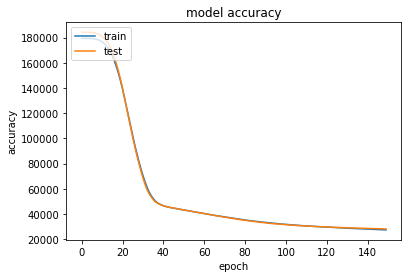

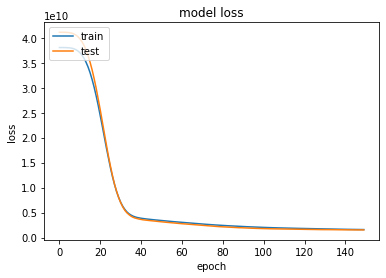

In [122]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Ploblem 6.

Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 1.0641 - accuracy: 0.7058 - val_loss: 0.3571 - val_accuracy: 0.9035
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3512 - accuracy: 0.9033 - val_loss: 0.3021 - val_accuracy: 0.9145
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2991 - accuracy: 0.9166 - val_loss: 0.2811 - val_accuracy: 0.9207
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2811 - accuracy: 0.9208 - val_loss: 0.2782 - val_accuracy: 0.9231
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2746 - accuracy: 0.9211 - val_loss: 0.2711 - val_accuracy: 0.9245
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2606 - accuracy: 0.9254 - val_loss: 0.2602 - val_accuracy: 0.9256
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2607 - accuracy: 0.9268 - val_loss: 0.2634 - val_accuracy: 0.9249
Epoch 

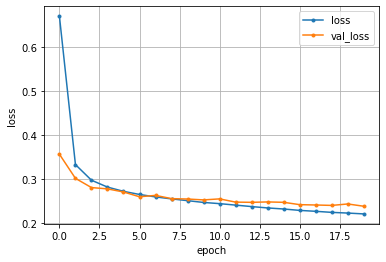

In [134]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
# x_train  = x_train.astype('float32')
# x_test   = x_test.astype('float32')
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(y_train, 10)
y_test   = keras.utils.to_categorical(y_test, 10)

# モデルの構築
# model = Sequential()
# model.add(InputLayer(input_shape=(784,)))
# model.add(Dense(10, activation='relu'))
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model = Sequential()
model.add(Dense(10, input_dim=784))    # 入力層4ノード, 隠れ層に10ノード, 全結合
model.add(Activation("relu"))    # 活性化関数はrelu
model.add(Dense(10)) # 出力層10ノード,全結合
model.add(Activation("softmax")) 
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 


# 学習
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 1.2570 - accuracy: 0.6054 - val_loss: 0.4280 - val_accuracy: 0.8800
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3977 - accuracy: 0.8877 - val_loss: 0.3137 - val_accuracy: 0.9131
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3154 - accuracy: 0.9130 - val_loss: 0.2883 - val_accuracy: 0.9183
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2855 - accuracy: 0.9194 - val_loss: 0.2756 - val_accuracy: 0.9223
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2697 - accuracy: 0.9249 - val_loss: 0.2678 - val_accuracy: 0.9262
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.2664 - accuracy: 0.9267 - val_loss: 0.2617 - val_accuracy: 0.9278
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2574 - accuracy: 0.9285 - val_loss: 0.2600 - val_accuracy: 0.9272
Epoch 

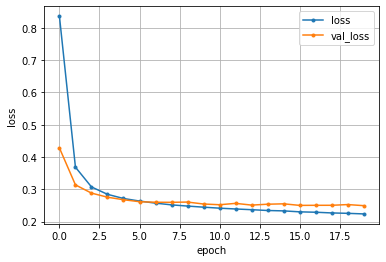

In [135]:
model = Sequential()
model.add(Dense(10, input_dim=784))    # 入力層784ノード, 隠れ層に10ノード, 全結合
model.add(Activation("relu"))    # 活性化関数はrelu
model.add(Dense(10)) # 出力層10ノード,全結合
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# 学習
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/20
3000/3000 [==============================] - 8s 2ms/step - loss: 0.7458 - accuracy: 0.7842 - val_loss: 0.3015 - val_accuracy: 0.91350s - l
Epoch 2/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.3039 - accuracy: 0.9126 - val_loss: 0.2856 - val_accuracy: 0.9212: 
Epoch 3/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2790 - accuracy: 0.9208 - val_loss: 0.2613 - val_accuracy: 0.9269
Epoch 4/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2519 - accuracy: 0.9293 - val_loss: 0.2530 - val_accuracy: 0.9302
Epoch 5/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2549 - accuracy: 0.9310 - val_loss: 0.2476 - val_accuracy: 0.9344
Epoch 6/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2485 - accuracy: 0.9341 - val_loss: 0.2453 - val_accuracy: 0.9317
Epoch 7/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2296 - accuracy: 0.9364 - val_loss: 0.2432 - val_a

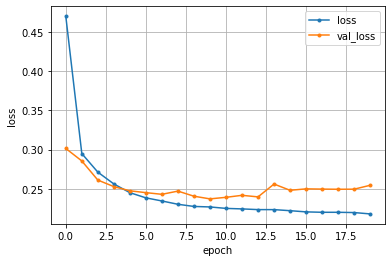

In [136]:
model = Sequential()
model.add(Dense(10, input_dim=784))    # 入力層4ノード, 隠れ層に10ノード, 全結合
model.add(Activation("relu"))    # 活性化関数はsigmoid
model.add(Dense(10)) # 出力層3ノード,全結合
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


# 学習
epochs = 20
batch_size = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Ploblem7(Adv).

### Ploblem8(Adv).